In [ ]:
!pip install scikit-learn Pillow matplotlib request pandas geopy

In [5]:
import pandas as pd
import requests
from io import BytesIO
from PIL import Image
import os

# read csv file
file_path = './plant_data.csv'
data = pd.read_csv(file_path)


data = data.head(1000)

In [6]:
data

,id,time_created,planter_id,image_url,lat,lon,gps_accuracy,token_id
0,997657,2020-11-12 07:19:11,5839,https://treetracker-production-images.s3.eu-ce...,8.451370,-13.172068,1.0,23ebbf42-0ad9-4293-b6f7-658f52e04a01
1,995667,2020-11-12 07:21:34,5876,https://treetracker-production-images.s3.eu-ce...,8.451370,-13.172115,1.0,NaN
2,997627,2020-11-12 07:23:51,5848,https://treetracker-production-images.s3.eu-ce...,8.451353,-13.172083,1.0,54ae9b81-82d3-43cd-953d-eda26775f488
3,995645,2020-11-12 07:24:36,5860,https://treetracker-production-images.s3.eu-ce...,8.451355,-13.172115,1.0,NaN
4,995487,2020-11-12 07:25:22,5832,https://treetracker-production-images.s3.eu-ce...,8.451342,-13.172035,1.0,NaN
...,...,...,...,...,...,...,...,...
995,993538,2020-11-21 14:27:30,5830,https://treetracker-production-images.s3.eu-ce...,8.452828,-13.173763,0.0,NaN
996,991686,2020-11-21 14:28:19,5843,https://treetracker-production-images.s3.eu-ce...,8.452792,-13.173783,0.0,NaN
997,997141,2020-11-21 14:30:15,5841,https://treetracker-production-images.s3.eu-ce...,8.452881,-13.173850,0.0,b101781a-1e91-4227-9c6a-5a49a8bc1608
998,991684,2020-11-21 14:30:59,5838,https://treetracker-production-images.s3.eu-ce...,8.452857,-13.173886,0.0,NaN


### Dowload images

In [7]:
# create folder
image_folder = 'plant_images'
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# download images
image_urls = data['image_url'].tolist()
image_paths = []

for idx, url in enumerate(image_urls):
    try:
        response = requests.get(url)
        image = Image.open(BytesIO(response.content))
        
        image_path = os.path.join(image_folder, f'image_{idx + 1}.jpg')
        image.save(image_path)
        
        image_paths.append(image_path)
    except Exception as e:
        print(f"Failed to download: {url}，error: {e}")


data['image_path'] = image_paths

       id         time_created  planter_id  \
0  997657  2020-11-12 07:19:11        5839   
1  995667  2020-11-12 07:21:34        5876   
2  997627  2020-11-12 07:23:51        5848   
3  995645  2020-11-12 07:24:36        5860   
4  995487  2020-11-12 07:25:22        5832   

                                           image_url       lat        lon  \
0  https://treetracker-production-images.s3.eu-ce...  8.451370 -13.172068   
1  https://treetracker-production-images.s3.eu-ce...  8.451370 -13.172115   
2  https://treetracker-production-images.s3.eu-ce...  8.451353 -13.172083   
3  https://treetracker-production-images.s3.eu-ce...  8.451355 -13.172115   
4  https://treetracker-production-images.s3.eu-ce...  8.451342 -13.172035   

   gps_accuracy                              token_id  \
0           1.0  23ebbf42-0ad9-4293-b6f7-658f52e04a01   
1           1.0                                   NaN   
2           1.0  54ae9b81-82d3-43cd-953d-eda26775f488   
3           1.0                 

In [8]:
data.head()

,id,time_created,planter_id,image_url,lat,lon,gps_accuracy,token_id,image_path
0,997657,2020-11-12 07:19:11,5839,https://treetracker-production-images.s3.eu-ce...,8.451370,-13.172068,1.0,23ebbf42-0ad9-4293-b6f7-658f52e04a01,plant_images/image_1.jpg
1,995667,2020-11-12 07:21:34,5876,https://treetracker-production-images.s3.eu-ce...,8.451370,-13.172115,1.0,NaN,plant_images/image_2.jpg
2,997627,2020-11-12 07:23:51,5848,https://treetracker-production-images.s3.eu-ce...,8.451353,-13.172083,1.0,54ae9b81-82d3-43cd-953d-eda26775f488,plant_images/image_3.jpg
3,995645,2020-11-12 07:24:36,5860,https://treetracker-production-images.s3.eu-ce...,8.451355,-13.172115,1.0,NaN,plant_images/image_4.jpg
4,995487,2020-11-12 07:25:22,5832,https://treetracker-production-images.s3.eu-ce...,8.451342,-13.172035,1.0,NaN,plant_images/image_5.jpg


### Image preprocessing

In [9]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from torchvision import models, transforms
import torch


# Load pre-trained ResNet 
resnet = models.resnet18(pretrained=True)
resnet.eval()

# Image transformation (Resize and Normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to extract features from an image
def extract_features(image_path, model):
    try:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0)  
        with torch.no_grad():
            features = model(image)
        return features.squeeze().numpy()  
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Extract features for all images
features = []
for idx, image_path in enumerate(image_paths):
    feature = extract_features(image_path, resnet)
    if feature is not None:
        features.append(feature)  

# Convert the extracted features to a NumPy array
features_np = np.array(features)


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


### Calculate geographic distance

In [43]:
from geopy.distance import geodesic

# calculate geographic distance
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    # Earth's radius in kilometers
    R = 6371.0
    distance = R * c
    return distance

# Compute the geographic distances between all pairs of images
latitudes = data['lat'].values
longitudes = data['lon'].values
geo_distances = np.zeros((len(latitudes), len(latitudes)))

# Compute the geographic distance matrix
for i in range(len(latitudes)):
    for j in range(i + 1, len(latitudes)):  
        distance = haversine(latitudes[i], longitudes[i], latitudes[j], longitudes[j])
        geo_distances[i, j] = distance
        geo_distances[j, i] = distance 

### Find top 5 neighbors

In [45]:
from sklearn.metrics.pairwise import cosine_similarity


# For each image, find the top 5 cosine similarity neighbors and calculate geographic distances
n_neighbors = 6  # Exclude the image itself
cos_sim = cosine_similarity(features_np)

 
# For each image, get the top 5 cosine similarity neighbors and compute the geographic distance
for idx, row in data.iterrows():
    # print(f"Image {idx + 1}:")
    # Get the top 5 most similar images based on cosine similarity (exclude itself)
    similar_indices = np.argsort(cos_sim[idx])[::-1][1:n_neighbors]  
    for i in similar_indices:
        
        geo_distance = geo_distances[idx, i]
        
        # print(f"  Neighbor {i + 1}: Cosine Similarity: {cos_sim[idx, i]:.4f}, Geographic Distance: {geo_distance:.2f} km")


In [46]:
import matplotlib.pyplot as plt
from PIL import Image

def show_neighbors(image_idx, n_neighbors=5):
    # Display the original image
    plt.figure(figsize=(15, 5))
    
    # Show the original image
    plt.subplot(1, n_neighbors + 1, 1)  # Adjust to show n_neighbors + original
    img = Image.open(image_paths[image_idx])
    plt.imshow(img)
    plt.title(f"Original Image\n{image_paths[image_idx].split('/')[-1]}")
    plt.axis('off')

    # Get the top n_neighbors most similar images based on cosine similarity (exclude itself)
    similar_indices = np.argsort(cos_sim[image_idx])[::-1][1:n_neighbors + 1]  # Skip the first index (itself)
    
    # Show the 5 nearest neighbors
    for i, neighbor_idx in enumerate(similar_indices, 1):
        # Show each neighbor image
        plt.subplot(1, n_neighbors + 1, i + 1)
        neighbor_img = Image.open(image_paths[neighbor_idx])
        plt.imshow(neighbor_img)
        
        # Get the cosine similarity and geographic distance
        cosine_similarity = cos_sim[image_idx][neighbor_idx]
        geo_distance = geo_distances[image_idx][neighbor_idx]
        
        # Display the title with cosine similarity and geographic distance
        image_num = image_paths[neighbor_idx].split('/')[-1]
        plt.title(f"Neighbor {i}\n{image_num}\nCosine Sim: {cosine_similarity:.3f}\nGeo Dist: {geo_distance:.2f} km")
        plt.axis('off')

    plt.show()


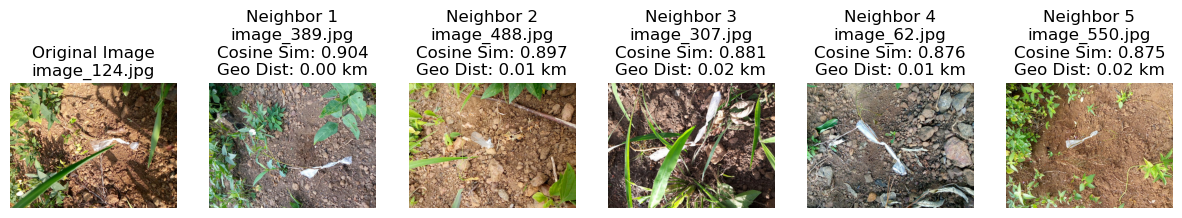

In [48]:
show_neighbors(123)

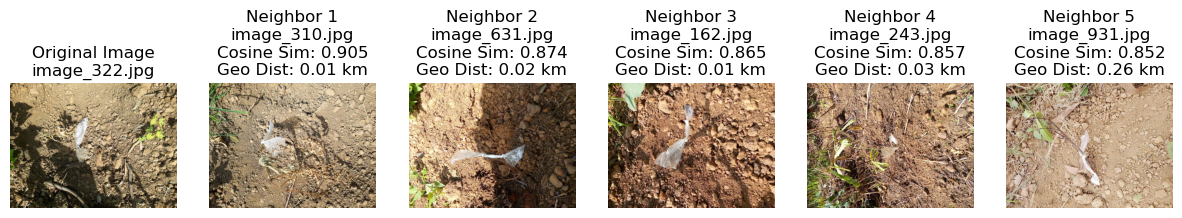

In [49]:
show_neighbors(321)